In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math

from sympy import symbols, Matrix

import picos

%matplotlib widget

def generate(n, k, h, psaved = 0):
    # Generate the vertices positions
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    p = np.array([(np.cos(a), np.sin(a)) for a in angles])
    
    # Generate the vertex indices as a set
    vertices = set(range(1, n + 1))
    
    # Generate the edges for the regular n-gon
    edges = []
    vertices_list = list(vertices)  # Convert set to list for indexing
    for i in range(n):
        edges.append((vertices_list[i], vertices_list[(i + 1) % n]))
    
    # Generate the edges for the star polygon with step size k
    for i in range(n):
        edges.append((vertices_list[i], vertices_list[(i + k) % n]))
    
    pbar = np.column_stack((p,np.ones(len(vertices))))

    ## Incidence Matrix 
    H = np.zeros([len(vertices),len(edges)]) # H is defined as a +-1 matrix, where the rows indicate the vertices and the columns, the edges. The sign is due to convention an indicates that it is a directed graph.
    for i in enumerate(edges): # First element from enumerate indicates edge index, the other is the vertices connected by it
        H[i[1][0]-1, i[0]] = 1 # i[1][0]-1 takes the first vertex index connected by the edge, the second element associates an edge to it. +1 due to convention
        H[i[1][1]-1, i[0]] = -1 # i[1][0]-1 takes the second vertex index connected by the edge, the second element associates an edge to it. -1 due to convention   

    E =pbar.T @ H @ np.diag(H[0,:]) # Creating the first element from which the matrix will be built.

    for i in range(1, len(vertices)): # Using a loop with a range from 1 to add the next elements
        E = np.append(E,pbar.T @ H @ np.diag(H.T[:,i]), axis = 0)
    ## SVD (Singular Value Decomposition)
    U, S, Vt = np.linalg.svd(E)

    rank = np.linalg.matrix_rank(E)
    Z = Vt[rank:,:].T # This z should represent a basis of the nullspace of E. To check it: E @ Z = 0

    Up, Sp, Vtp = np.linalg.svd(pbar)

    d = len(p[0]) # Dimensions
    U2 = Up[:, 1+d:] # The rest of the columns are U2

    # In this case Z only has 1 column, but in case there were more, we have to make a loop for each column.
    M = [] # We create it as a list so it will be storing each matrix resulting from each i separatedly, that way we will be able to call it after individually.
    for i in range(Z.shape[1]): # Loops for each column of Z
        M.append(U2.T @ H @ np.diag(Z[:,i]) @ H.T @ U2)

    P = picos.Problem()
    c = picos.RealVariable("c", len(M))
    M_i = [picos.Constant(Mi) for Mi in M]
    Sum = picos.sum(c[i] * M_i[i] for i in range(len(M_i)))
    P.add_constraint(Sum>>0)
    P.solve()

    ci = np.array([c.np])

    try:
        w = sum(ci[i] * Z[:,i] for i in range(len(c)))
    except:
        w = [sum(Z[:,i]*ci[0][i] for i in range(Z.shape[1]))]
        w = w[0]

    Omega = H @ np.diag(w) @ H.T

    Prs = np.reshape(p,[2*p.shape[0],1]) #posisciones de referencia apiladas
    I = np.eye(2)
    Lbar = np.kron(Omega, I)

    pstack = np.array([p.flatten()]).T

    pdot = -h * Lbar * pstack

    Pt = pstack.copy()
    dt = 0.01
    tf = 200
    tp = tf/5000
    t = 0
    if type(psaved) == int:
        Pt = 5*np.random.rand(len(pstack),1)
    else:
        Pt = psaved
    Psave = Pt.copy()
    fig, ax = plt.subplots(dpi = 150)



    plt.plot(Pt[0::2,0],Pt[1::2,0],'xk',linewidth =0.1, label = "Posiciones iniciales")
    # plt.xlim([min(Pt) - 0.1, max(Pt) + 0.1])
    # plt.ylim([min(Pt) - 0.1, max(Pt) + 0.1])

    trajx = []
    trajy = []
    times = []

    while t <= tf:
        t += dt
        if t >= tp:
            # plt.plot(Pt[0::2,0],Pt[1::2,0],'.', markersize = 0.5)
            trajx.append(Pt[0::2,0])
            trajy.append(Pt[1::2,0])
            times.append(t)
            tp += tf/3000
        #consenso lo ejecuto siempre como referencia
            
        Pt = Pt - h*np.kron(Omega,I)@Pt*dt

    # cmap = plt.get_cmap('Set3')
    # norm = plt.Normalize(vmin=0, vmax=np.array(trajx).shape[1] - 1)
    # colors = cmap(norm(np.arange(np.array(trajx).shape[1])))
    # plt.gca().set_prop_cycle(color=colors)
    plt.plot(np.array(trajx),np.array(trajy), linewidth = 0.6, alpha = 0.8)
    plt.plot(Pt[0::2,0],Pt[1::2,0],'^r', markersize = 0.7)

    Pst = np.array([Pt[0::2,0],Pt[1::2,0]]).T
    # for i in enumerate(Pst):
    #     plt.gca().text(i[1][0],i[1][1],str(i[0]+1))
    for i in enumerate(edges):
        plt.plot(Pst[[i[1][0]-1,i[1][1]-1],0],Pst[[i[1][0]-1,i[1][1]-1],1], color = "black", linewidth = 0.3, linestyle = "--", alpha=0.7)


    # plt.title("Desde posiciones arbitrarias")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(alpha = 0.7 ,linestyle='--', linewidth=0.3)
    plt.legend()
    # inset_ax = fig.add_axes([0.17, 0.6, 0.25, 0.25])  # [left, bottom, width, height]
    # inset_ax.plot(Pt[0::2,0],Pt[1::2,0],'^r', markersize = 0.7)
    # inset_ax.plot(trajx,trajy, linewidth = 0.5, alpha = 0.4)
    # for i in enumerate(edges):
    #     inset_ax.plot(Pst[[i[1][0]-1,i[1][1]-1],0],Pst[[i[1][0]-1,i[1][1]-1],1], color = "black", linewidth = 0.5, linestyle = "--", alpha=0.7)
 

    # # Configurar el gráfico insertado
    # inset_ax.set_xlim(2.35, 2.8)
    # inset_ax.set_ylim(1.7, 2.9)
    # inset_ax.grid(True)
    # inset_ax.tick_params(axis='both', labelsize=6)

    # Mostrar el gráfico

    plt.show()
    
    x = np.array(trajx)
    y = np.array(trajy)

    r = [0]*x.shape[1]
    for i in range(len(r)):
        vect = np.array([x[:,i],y[:,i]])
        norms = np.array([])
        for j in range(vect.shape[1]):
            norms = np.append(norms,np.linalg.norm(vect[:,j]))
        r[i] = norms
    r = np.array(r)

    tq = np.array(times)
    vel = [0]*x.shape[1]

    plt.figure()
    for i in range(x.shape[1]):
        vel[i] = np.diff(r[i,:])/np.diff(tq)
        plt.plot(tq[:-1] ,vel[i], label = i+1, linewidth = 0.8)

    # plt.title("Velocidades de los agentes")
    plt.xlabel("t (s)")
    plt.ylabel("Velocidad")
    plt.grid(linewidth=0.2)
    # plt.xlim(left = -1, right = 30)
    # plt.legend()
    plt.show()
    return Psave, trajx, trajy, edges
    


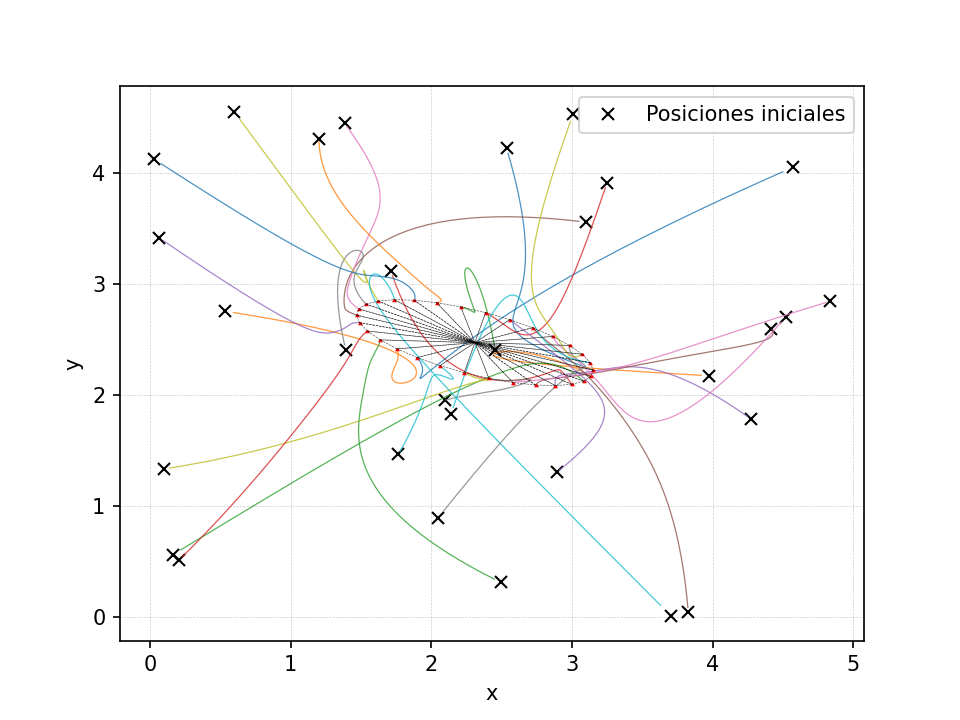

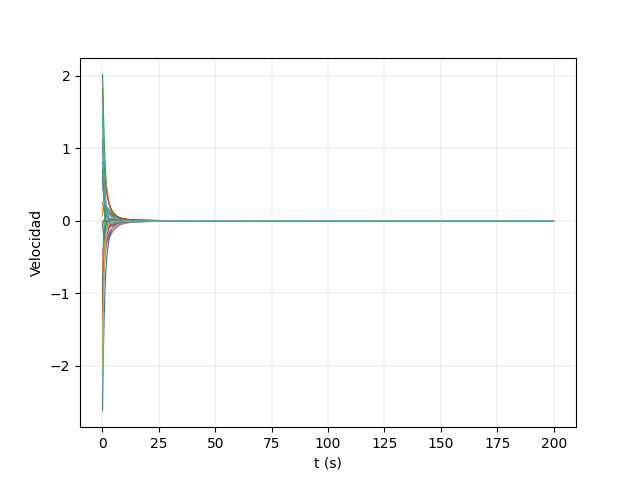

In [4]:
psaved, trajx, trajy, edges = generate(30,15,0.8, psaved)